In [53]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [54]:
limit_mem()

In [108]:
path = '/data/chuanleiguo/data/imagenet/sample/'
dpath = "/data/chuanleiguo/data/imagenet/sample/"

### Setup

In [56]:
fnames = glob.glob(path + "**/*.JPEG", recursive=True)
n = len(fnames); n

19439

In [57]:
fn = fnames[50]; fn

'/data/chuanleiguo/data/imagenet/sample/train/n12768682/n12768682_42914.JPEG'

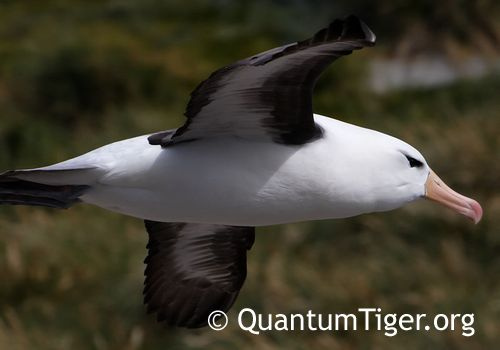

In [58]:
img = Image.open(fnames[20]); img

In [59]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [60]:
deproc = lambda x, s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [61]:
arr = np.array(img); arr.shape

(350, 500, 3)

In [62]:
arr = np.expand_dims(arr, 0); arr.shape

(1, 350, 500, 3)

In [63]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

## Recreate input

In [64]:
model = VGG16_Avg(include_top=False)

In [65]:
layer = model.get_layer("block5_conv1").output

In [66]:
type(layer)

tensorflow.python.framework.ops.Tensor

In [67]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [68]:
class Evaluator(object):
    def __init__(self, f, shp):
        self.f, self.shp = f, shp
    
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x):
        return self.grad_values.flatten().astype(np.float64)

In [69]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss] + grads)
evaluator = Evaluator(fn, shp)

In [70]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, 
                                         maxfun=20)
        x = np.clip(x, -127, 127)
        print("Current loss value: ", min_val)
        imsave(f'{path}results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

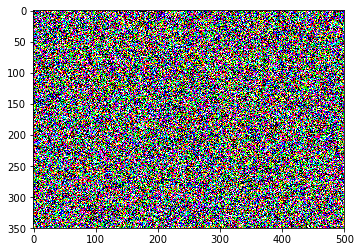

In [71]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 100
x = rand_img(shp)
plt.imshow(x[0])

In [72]:
iterations = 10

In [73]:
x = solve_image(evaluator, iterations, x)

Current loss value:  61.2246665955
Current loss value:  21.0033435822
Current loss value:  12.4156455994
Current loss value:  9.21941375732
Current loss value:  7.47040891647
Current loss value:  6.39568185806
Current loss value:  5.66378355026
Current loss value:  5.1701259613
Current loss value:  4.77632665634
Current loss value:  4.44512844086


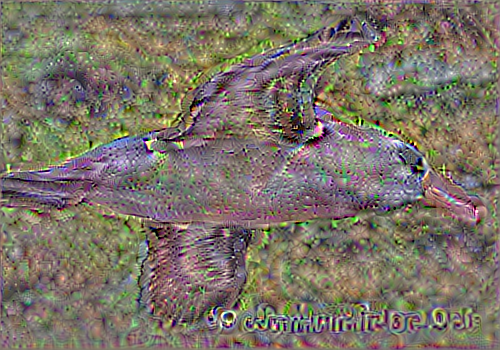

In [74]:
Image.open(path + 'results/res_at_iteration_9.png')

In [75]:
from IPython.display import HTML
from matplotlib import animation, rc

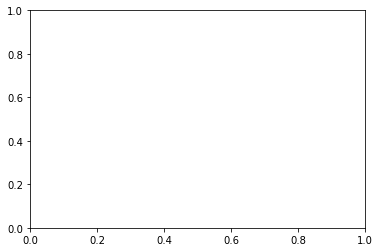

In [76]:
fig, ax = plt.subplots()
def animate(i):
    ax.imshow(Image.open(f'{path}results/res_at_iteration_{i}.png'))

In [77]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

### Recreate style

In [78]:
def plot_arr(arr): 
    plt.imshow(deproc(arr, arr.shape)[0].astype('uint8'))

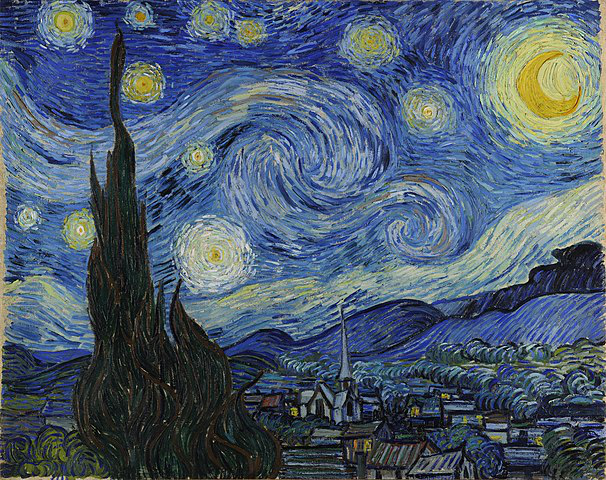

In [79]:
style = Image.open('/data/chuanleiguo/data/starry_night.jpg')
style = style.resize(np.divide(style.size,1).astype('int32')); style

In [80]:
#style = Image.open('/data/chuanleiguo/data/bird.jpg')
#style = style.resize(np.divide(style.size,2.4).astype('int32')); style

In [81]:
#style = Image.open('/data/chuanleiguo/data/simpsons.jpg')
#style = style.resize(np.divide(style.size, 1).astype('int32')); style

In [82]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [83]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

In [84]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [85]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [86]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [87]:
def style_loss(x, targ):
    return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [88]:
loss = sum(style_loss(l1[0], l2[0]) for l1, l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss] + grads)
evaluator = Evaluator(style_fn, shp)

In [89]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0, 2, 2, 0])

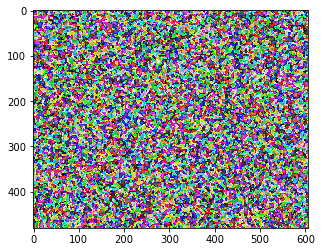

In [90]:
plt.imshow(x[0])

In [91]:
iterations = 10
x = rand_img(shp)

In [92]:
x = solve_image(evaluator, iterations, x)

Current loss value:  17062.890625
Current loss value:  671.137329102
Current loss value:  150.159164429
Current loss value:  85.8915252686
Current loss value:  57.4511489868
Current loss value:  40.3108634949
Current loss value:  27.6675376892
Current loss value:  17.3736133575
Current loss value:  12.0290975571
Current loss value:  9.33834934235


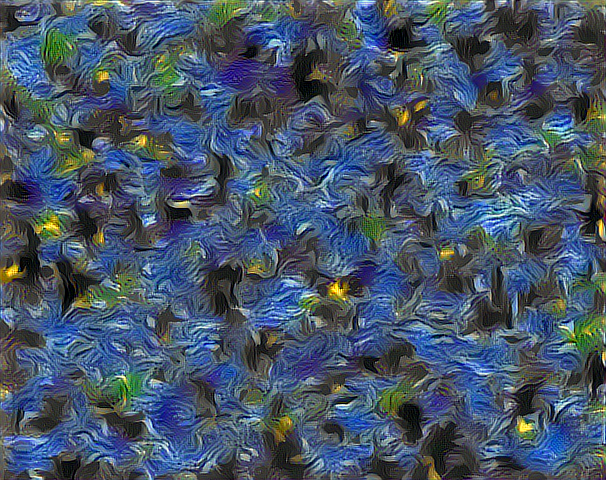

In [93]:
Image.open(path + 'results/res_at_iteration_9.png')

### Style transfer

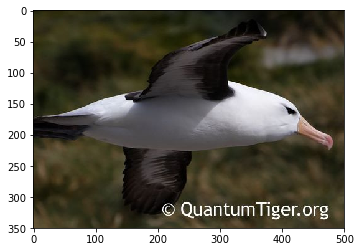

In [94]:
w, h = style.size
src = img_arr[:, :h, :w]
plot_arr(src)

In [95]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [96]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [97]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

ValueError: Error when checking : expected input_5 to have shape (None, 480, 606, 3) but got array with shape (1, 350, 500, 3)

In [ ]:
style_wgts = [0.05, 0.2, 0.2, 0.25, 0.3]

In [ ]:
loss = sum(style_loss(l1[0], l2[0]) * w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ) / 10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss] + grads)

In [ ]:
evaluator = Evaluator(transfer_fn, shp)

In [ ]:
iterations=10
x = rand_img(shp)

In [ ]:
x = solve_image(evaluator, iterations, x)

In [ ]:
Image.open(path + 'results/res_at_iteration_9.png')

## Use content loss to creat a super-resolution network

In [109]:
arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:]

In [ ]:
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:]

In [110]:
parms = {"verbose": 0, "callbacks": [TQDMNotebookCallback(leave_inner=True)]}

In [111]:
def conv_block(x, filters, size, stride=(2, 2), mode="same", act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation("relu")(x) if act else x

In [112]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1, 1))
    x = conv_block(x, nf, 3, (1, 1), act=False)
    return merge([x, ip], mode="sum")

In [113]:
def deconv_block(x, filters, size, shape, stride=(2, 2)):
    x = Deconvolution2D(filters, size, size, subsample=stride,
                       border_mode="same", output_shpe=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation("relu")(x)

In [114]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode="same")(x)
    x = BatchNormalization(mode=2)(x)
    return Activation("relu")(x)

In [115]:
inp = Input(arr_lr.shape[1:])
x = conv_block(inp, 64, 9, (1, 1))
for i in range(4):
    x = res_block(x)
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x = Convolution2D(3, 9, 9, activation="tanh", border_mode="same")(x)
outp = Lambda(lambda x: (x + 1) * 127.5)(x)

In [121]:
shp = arr_lr.shape[1:]

In [122]:
vgg_inp = Input(shp)
vgg = VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [123]:
for l in vgg.layers:
    l.trainable = False

In [124]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [125]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [126]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [127]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

ValueError: Dimensions must be equal, but are 72 and 288 for 'sub_22' (op: 'Sub') with input shapes: [?,72,72,64], [?,288,288,64].

In [ ]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, **parms)

In [ ]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, **parms)

In [ ]:
top_model = Model(inp, outp)

In [ ]:
plt.imshow(arr_lr[10].astype('uint8'));

In [ ]:
plt.imshow(p[0].astype('uint8'));

In [ ]:
top_model.save_weights(dpath+'sr_final.h5')

In [ ]:
top_model.load_weights(dpath+'top_final.h5')

## Fast style transfer

In [128]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [129]:
inp = Input((288,288,3))
ref_model = Model(inp, ReflectionPadding2D((40,10))(inp))
ref_model.compile('adam', 'mse')

In [ ]:
p = ref_model.predict(arr_hr[10:11])

In [ ]:
plt.imshow(p[0].astype('uint8'));

### Main algorithm

In [ ]:
shp = arr_hr.shape[1:]

In [ ]:
style = Image.open('data/starry_night.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32'))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);

In [ ]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

In [ ]:
inp=Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

In [ ]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [ ]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

In [ ]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [ ]:
[K.eval(K.shape(o)) for o in style_targs]

In [ ]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [ ]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [ ]:
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [ ]:
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [ ]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ, 8, 2, **parms)

In [ ]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 16, 1, **parms)

In [ ]:
top_model = Model(inp, outp)

In [ ]:
p = top_model.predict(arr_hr[:20])

In [ ]:
plt.imshow(np.round(p[1]).astype('uint8'));

In [ ]:
top_model.save_weights(dpath+'style_final.h5')

In [ ]:
top_model.load_weights(dpath+'style_final.h5')